In [272]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

In [273]:
#Метрика Мінковського
P = 4

d_Min = lambda x_i, x_j: sum((x_i[k] - x_j[k]) ** P for k in range(len(x_i))) ** (1 / P)

Q3 = lambda clusters, a, n: sum(
    sum(d_Min(a[i], n[j]) for i in cluster for j in cluster)
    for cluster in clusters
)

In [274]:
df = pd.read_csv('data.csv')
df = df.dropna(subset=['score'])
df = df.dropna(subset=['genres'])

#Якщо є декілька жанрів то обираємо перштий та пропоускаємо 'Award Winning'
df['primary_genre'] = df['genres'].str.split(', ').apply(
    lambda genres: next((g for g in genres if g != 'Award Winning'), 'Unknown')
)

df = df[df['primary_genre'] != 'Unknown']
df['cluster'] = 1
df

,anime_id,anime_url,image_url,name,english_name,japanese_names,score,genres,themes,demographics,...,source,duration,rating,rank,popularity,favorites,scored_by,members,primary_genre,cluster
0,52991,https://myanimelist.net/anime/52991/Sousou_no_...,https://cdn.myanimelist.net/images/anime/1015/...,Sousou no Frieren,Frieren: Beyond Journey's End,葬送のフリーレン,9.31,"Adventure, Drama, Fantasy",NaN,Shounen,...,Manga,24 min per ep,PG-13 - Teens 13 or older,1.0,160,63387,605478,1038347,Adventure,1
1,5114,https://myanimelist.net/anime/5114/Fullmetal_A...,https://cdn.myanimelist.net/images/anime/1208/...,Fullmetal Alchemist: Brotherhood,Fullmetal Alchemist: Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,9.10,"Action, Adventure, Drama, Fantasy",Military,Shounen,...,Manga,24 min per ep,R - 17+ (violence & profanity),2.0,3,232007,2196965,3484360,Action,1
2,9253,https://myanimelist.net/anime/9253/Steins_Gate,https://cdn.myanimelist.net/images/anime/1935/...,Steins;Gate,Steins;Gate,STEINS;GATE,9.07,"Drama, Sci-Fi, Suspense","Psychological, Time Travel",NaN,...,Visual novel,24 min per ep,PG-13 - Teens 13 or older,3.0,14,194580,1450481,2669303,Drama,1
3,60022,https://myanimelist.net/anime/60022/One_Piece_...,https://cdn.myanimelist.net/images/anime/1455/...,One Piece Fan Letter,NaN,ONE PIECE FAN LETTER,9.06,"Action, Adventure, Fantasy",NaN,Shounen,...,Light novel,24 min,PG-13 - Teens 13 or older,4.0,2334,1976,69555,92128,Action,1
4,38524,https://myanimelist.net/anime/38524/Shingeki_n...,https://cdn.myanimelist.net/images/anime/1517/...,Shingeki no Kyojin Season 3 Part 2,Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,9.05,"Action, Drama, Suspense","Gore, Military, Survival",Shounen,...,Manga,23 min per ep,R - 17+ (violence & profanity),5.0,21,60535,1671960,2409440,Action,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14993,49922,https://myanimelist.net/anime/49922/Rape_Rape_...,https://cdn.myanimelist.net/images/anime/1807/...,Rape! Rape! Rape! DVD-Box Special,NaN,レイプ！レイプ！レイプ！DVD-BOX 特典映像,5.57,Hentai,NaN,NaN,...,Visual novel,1 min,Rx - Hentai,NaN,13969,1,243,1082,Hentai,1
14994,9211,https://myanimelist.net/anime/9211/Shikatte_In...,https://cdn.myanimelist.net/images/anime/8/309...,Shikatte Ingo: Misaki Shunin no Buka Kyouiku-hen,Scold with Dirty Words,叱って淫語 三咲主任の部下教育編,5.57,Hentai,NaN,NaN,...,Original,17 min,Rx - Hentai,NaN,9923,6,1271,3634,Hentai,1
14995,4840,https://myanimelist.net/anime/4840/MEM__Yogosa...,https://cdn.myanimelist.net/images/anime/1891/...,M.E.M.: Yogosareta Junketsu,M.E.M.: Lost Virginity,M.E.M.～汚された純潔～,5.57,Hentai,NaN,NaN,...,Visual novel,28 min per ep,Rx - Hentai,NaN,11427,4,680,2315,Hentai,1
14996,35996,https://myanimelist.net/anime/35996/Naeil-eun_...,https://cdn.myanimelist.net/images/anime/11/86...,Naeil-eun Pyeongbeomhae Jilgeoya,I Will Be Normal Tomorrow,내일은 평범해질거야,5.57,"Romance, Sci-Fi",NaN,NaN,...,Original,4 min,G - All Ages,11903.0,18071,1,138,414,Romance,1


In [275]:
X = df[['score']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Візуалізація даних

In [276]:
def vizualize_clusters(df, display_clusters=True):
    plt.figure(figsize=(14, 10))

    # Define a colormap for clusters - fixing the key type issue
    unique_clusters = sorted(df['cluster'].unique())
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
    cluster_colors = {int(cluster): colors[i] for i, cluster in enumerate(unique_clusters)}

    already_labeled = set()

    genres_by_score = df.groupby('primary_genre')['score'].mean().sort_values(ascending=False)
    genres_order = genres_by_score.index.tolist()

    for i, genre in enumerate(genres_order):
        genre_data = df[df['primary_genre'] == genre]

        for cluster in sorted(genre_data['cluster'].unique()):
            cluster_points = genre_data[genre_data['cluster'] == cluster]
            genre_scores = cluster_points['score']

            y_jitter = np.random.normal(i + 1, 0.1, size=len(genre_scores))

            label = f'Cluster {int(cluster)}' if cluster not in already_labeled and display_clusters else ""
            if label:
                already_labeled.add(cluster)

            plt.scatter(genre_scores, y_jitter, alpha=0.6, s=25,
                        color=cluster_colors[int(cluster)],
                        label=label)

        mean_score = genre_data['score'].mean()
        plt.axvline(x=mean_score, ymin=(i / len(genres_order)),
                    ymax=((i + 1) / len(genres_order)),
                    color='darkred', linestyle='-', linewidth=2)

        plt.text(mean_score + 0.05, i + 1, f"{mean_score:.2f}",
                 va='center', ha='left', color='darkred', fontweight='bold')

        plt.text(df['score'].max() + 0.5, i + 1, f"n={len(genre_data)}",
                 va='center', ha='left', color='dimgray')

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right')

    plt.yticks(range(1, len(genres_order) + 1), genres_order)
    plt.title('Аніме за рейтингом та жанром', fontsize=14)
    plt.xlabel('Рейтинг', fontsize=12)
    plt.ylabel('Основний жанр', fontsize=12)
    plt.grid(axis='x', alpha=0.3)
    plt.xlim(df['score'].min() - 0.5, df['score'].max() + 1)
    plt.tight_layout()
    plt.show()

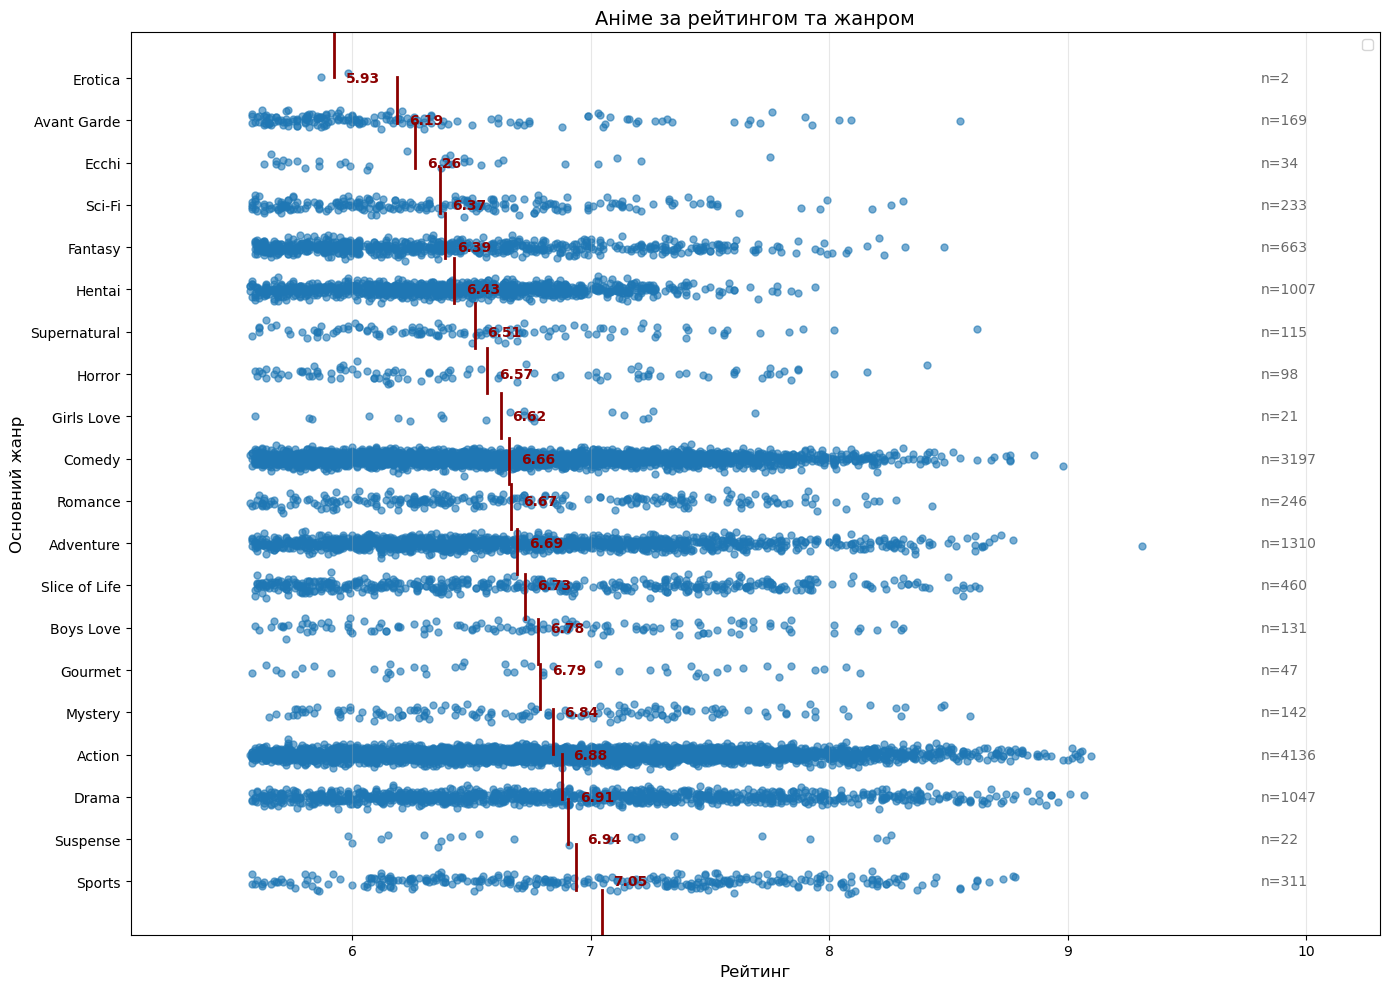

In [277]:
vizualize_clusters(df, display_clusters=False)

## Обрахунок кількості кластерів

In [278]:
def kmeans(X, k, p=4, max_iters=1000):
    n = len(X)
    indices = np.random.choice(n, k, replace=False)
    centers = X[indices]

    labels = np.zeros(n)
    prev_labels = np.ones(n)

    iter = 0
    for i in range(max_iters):
        iter += 1

        for j in range(n):
            distances = [d_Min(X[j], centers[c]) for c in range(k)]
            labels[j] = np.argmin(distances)

        if np.array_equal(labels, prev_labels):
            break

        prev_labels = labels.copy()

        for j in range(k):
            cluster_points = X[labels == j]
            if len(cluster_points) > 0:
                centers[j] = np.mean(cluster_points, axis=0)

    clusters = [np.where(labels == i)[0] for i in range(k)]
    inertia = 0
    for i, cluster in enumerate(clusters):
        inertia += sum(d_Min(X[j], centers[i]) for j in cluster)

    return labels, centers, iter, inertia


In [279]:
k_values = range(2, 11)
inertias = []
iterations_list = []
decreases = []

for k in k_values:
    labels, centers, iterations, inertia = kmeans(X_scaled, k)
    inertias.append(inertia)
    iterations_list.append(iterations)

    d = 0
    if len(inertias) > 1:
        d = (inertias[-2] - inertias[-1]) / inertias[-2] * 100
    decreases.append(d)

    print(f"k={k}, iterations={iterations}, inertia={inertia:.4f}, decrease={d:.2f}%")

k=2, iterations=10, inertia=6117.9559, decrease=0.00%
k=3, iterations=19, inertia=4478.0148, decrease=26.81%
k=4, iterations=8, inertia=3334.9186, decrease=25.53%
k=5, iterations=37, inertia=2743.7718, decrease=17.73%
k=6, iterations=40, inertia=2261.8890, decrease=17.56%
k=7, iterations=14, inertia=1934.6831, decrease=14.47%
k=8, iterations=24, inertia=1709.6935, decrease=11.63%
k=9, iterations=13, inertia=1528.4411, decrease=10.60%
k=10, iterations=18, inertia=1368.4372, decrease=10.47%


In [280]:
pct_changes = decreases[1:]
pct_diffs = [pct_changes[i] - pct_changes[i + 1] for i in range(len(pct_changes) - 1)]
print(f"Різниця між спадами: {[f'{diff:.2f}%' for diff in pct_diffs]}")

elbow_idx = np.argmax(pct_diffs) + 1
optimal_k = k_values[elbow_idx]
print(f"k оптимальний = {optimal_k}.")

Різниця між спадами: ['1.28%', '7.80%', '0.16%', '3.10%', '2.84%', '1.03%', '0.13%']
k оптимальний = 4.


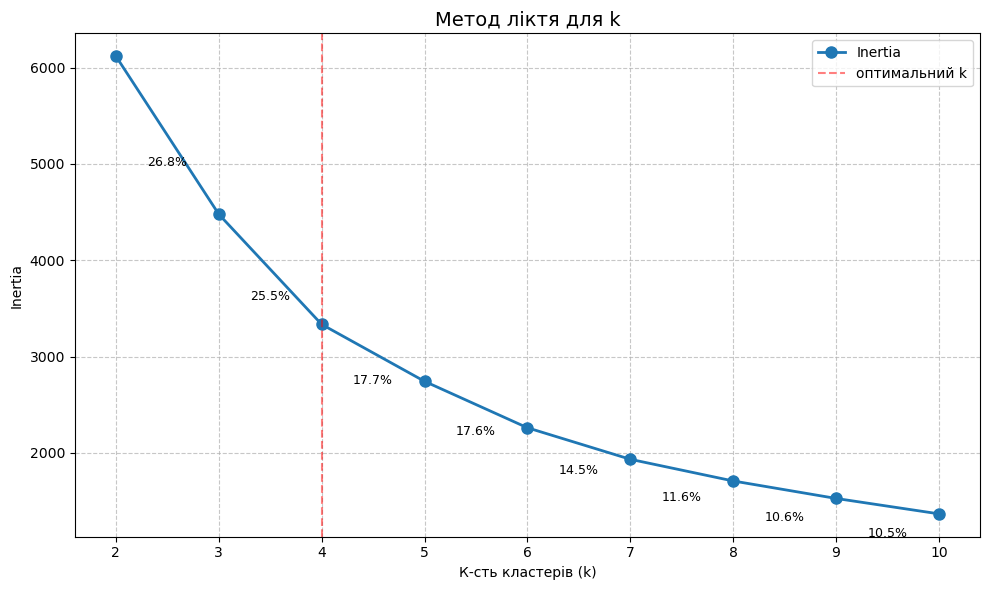

In [281]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, 'o-', linewidth=2, markersize=8, label='Inertia')
for i in range(1, len(k_values)):
    plt.annotate(f"{decreases[i]:.1f}%",
                 xy=((k_values[i - 1] + k_values[i]) / 2, (inertias[i - 1] + inertias[i]) / 2),
                 xytext=(0, -15), textcoords='offset points',
                 ha='center', va='top', fontsize=9)

plt.axvline(x=optimal_k, color='r', linestyle='--', alpha=0.5, label='оптимальний k')
plt.title('Метод ліктя для k', fontsize=14)
plt.xlabel('К-сть кластерів (k)')
plt.ylabel('Inertia')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

## Розподіл по кластерам

#### Кластеризація з визначеним к

In [282]:
optimal_labels, optimal_centers, _, _ = kmeans(X_scaled, optimal_k)
df['cluster'] = optimal_labels

##### Обрахунок центрів кластерів

In [283]:
clusters = sorted(df['cluster'].unique())
centers_dict = {}

for cluster in clusters:
    cluster_data = df[df['cluster'] == cluster]
    center = cluster_data['score'].mean()
    centers_dict[int(cluster)] = round(center, 2)

print("Центри кластерів:")
for cluster, center in centers_dict.items():
    print(f"Cluster {cluster}: {center}")

Центри кластерів:
Cluster 0: 5.92
Cluster 1: 6.55
Cluster 2: 8.03
Cluster 3: 7.24


#### Візуалізація кластерів

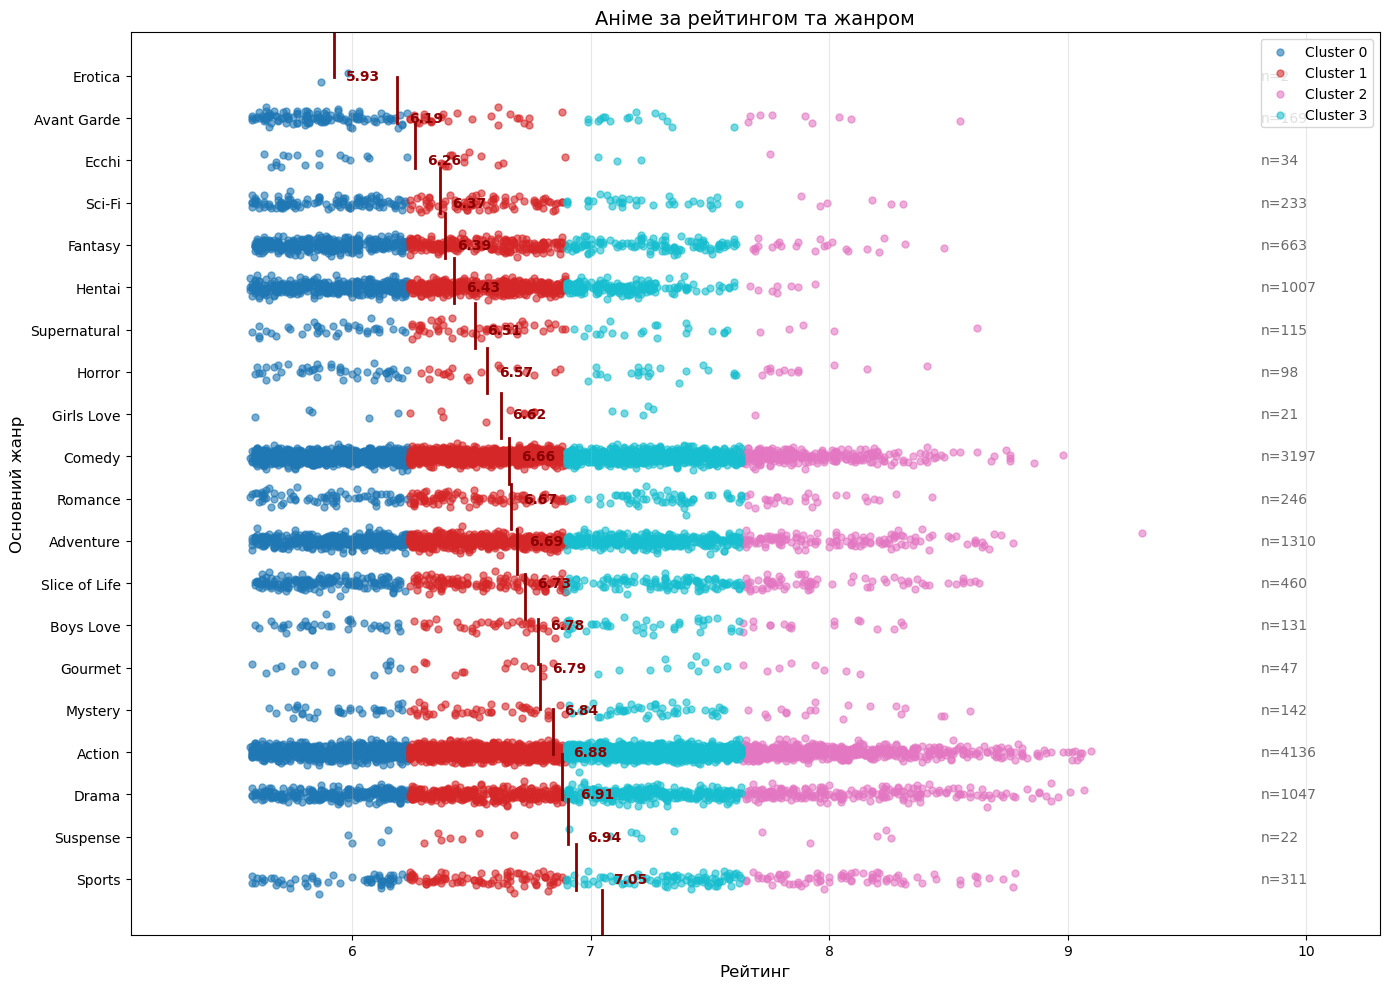

In [284]:
vizualize_clusters(df, display_clusters=True)